In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from dataloaders import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireLayer
from spiking.learning import STDP
from spiking.competition import WinnerTakesAll
from visualization import SpikesVisualization

In [3]:
dataloader = MnistSpikesDataloader("./data/mnist-subset", 'train')
validation_dataloader = MnistSpikesDataloader("./data/mnist-subset", 'test')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

max_input_spikes = 1568


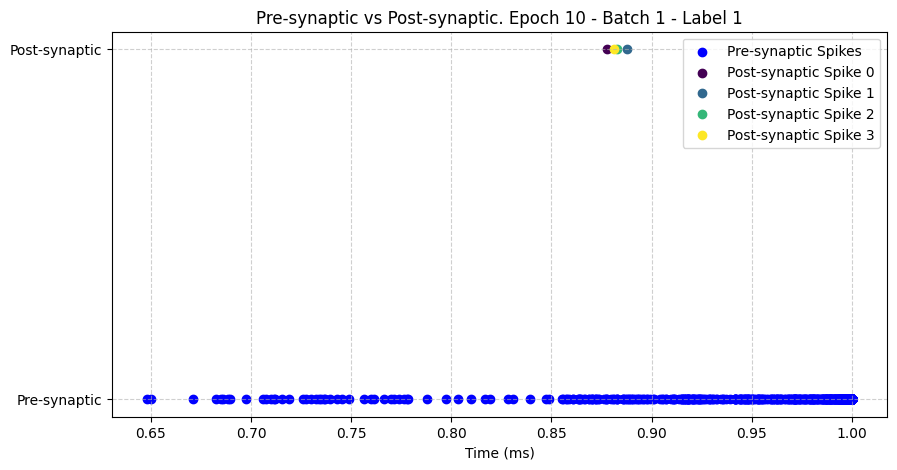

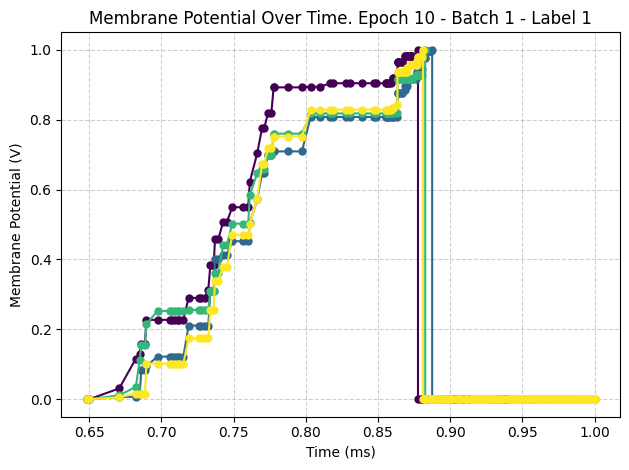

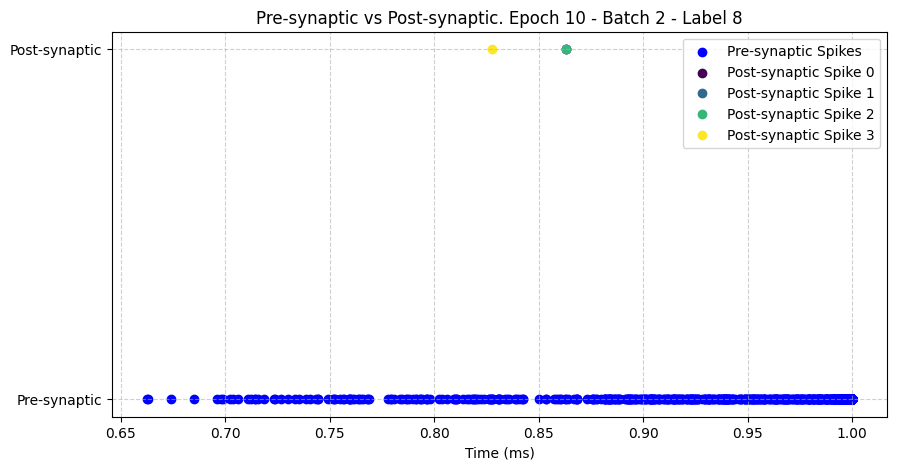

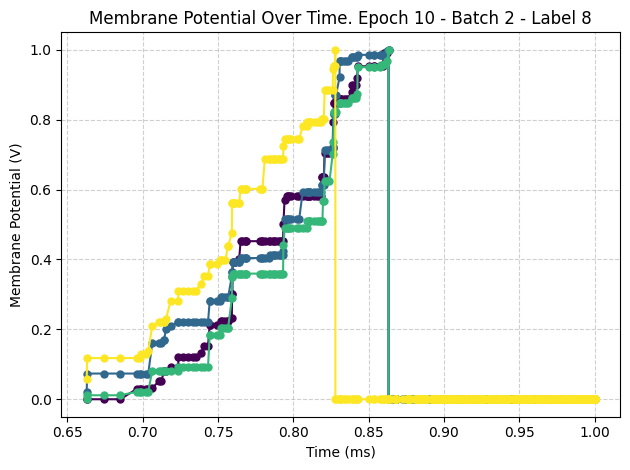

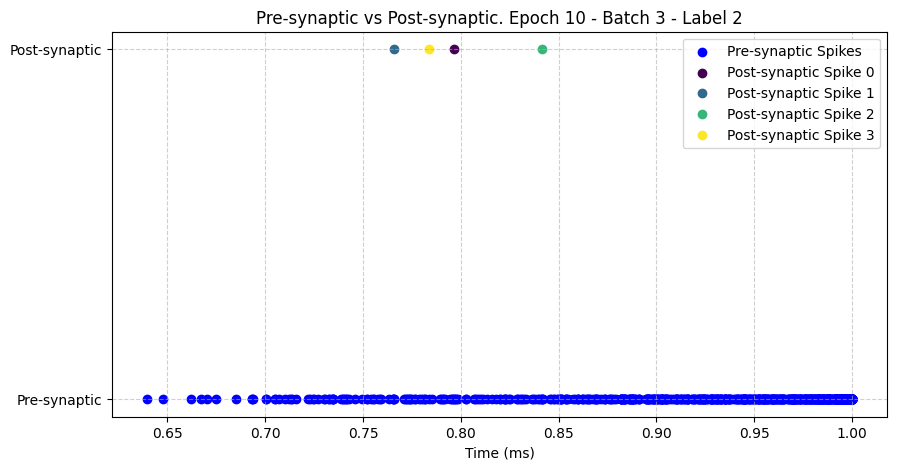

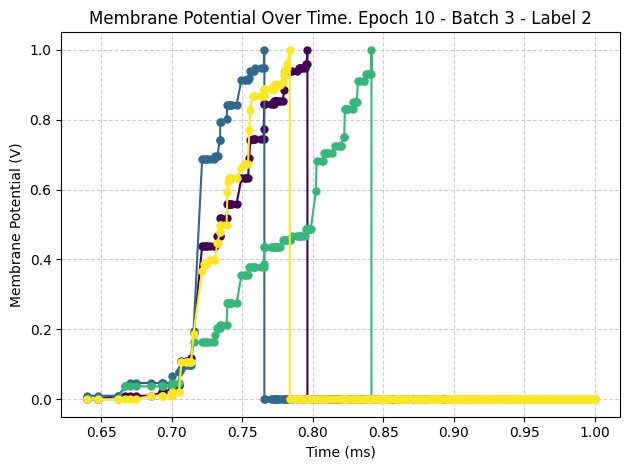

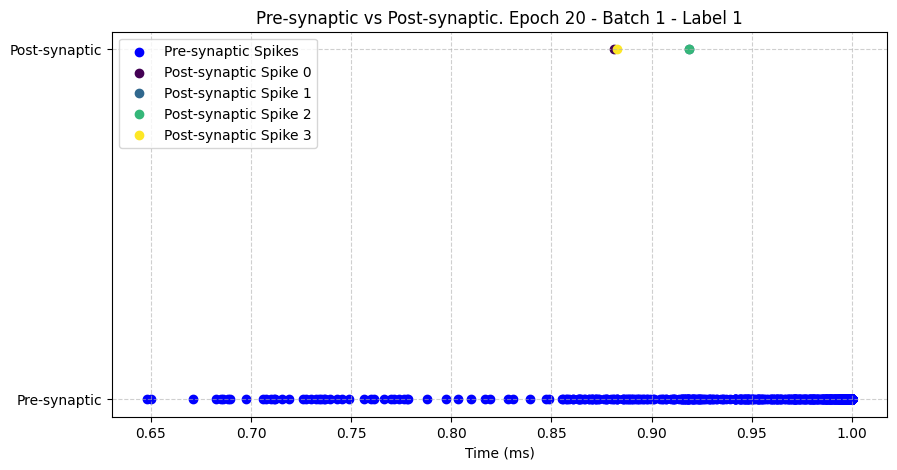

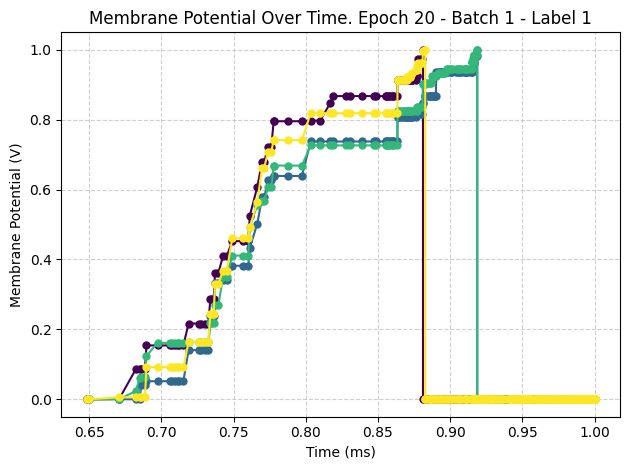

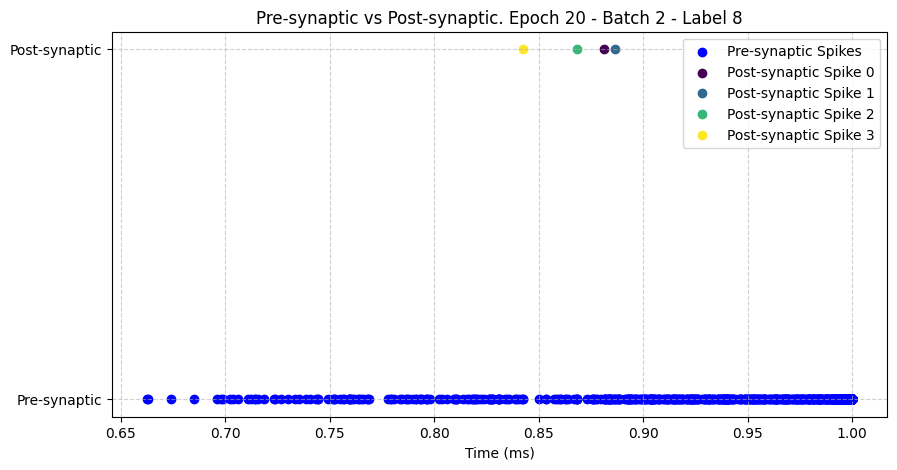

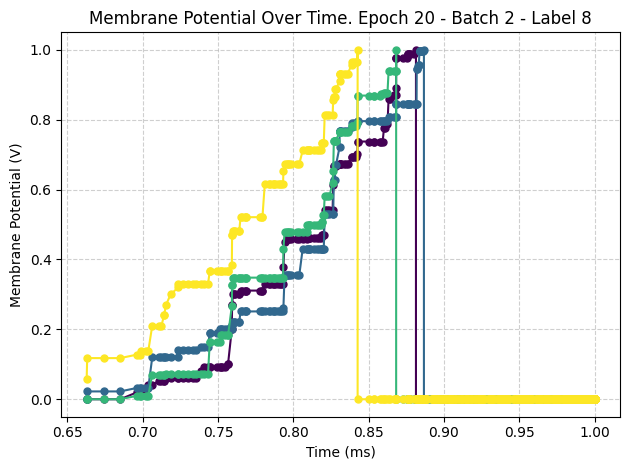

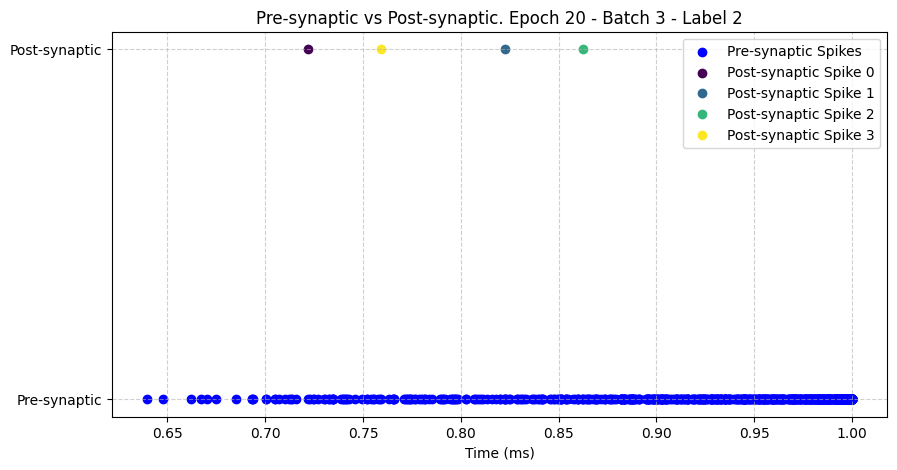

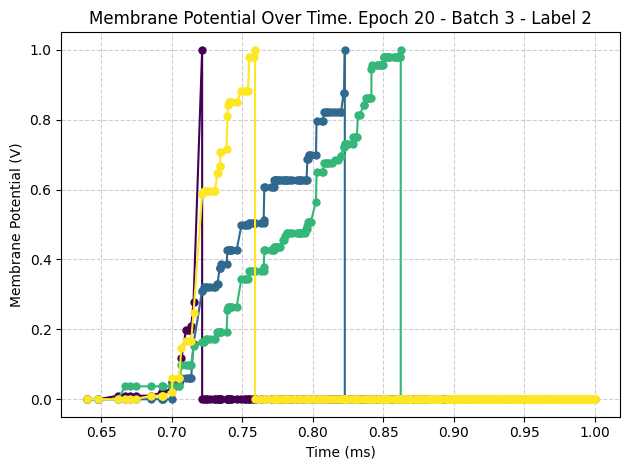

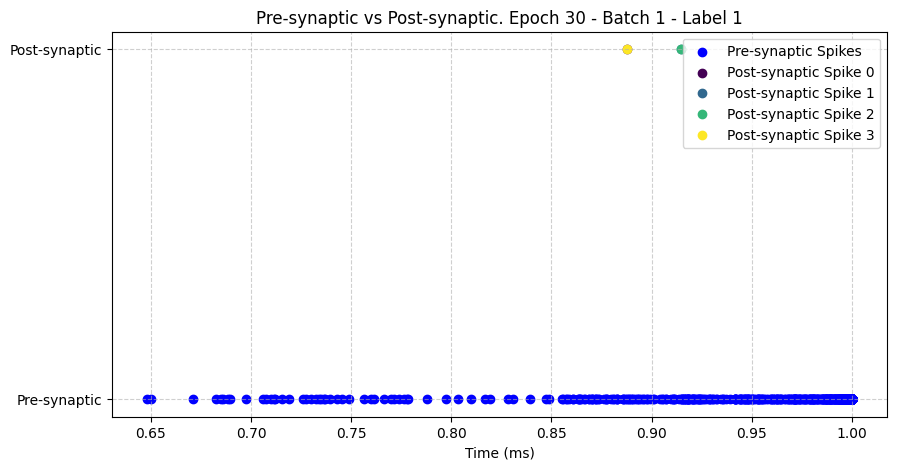

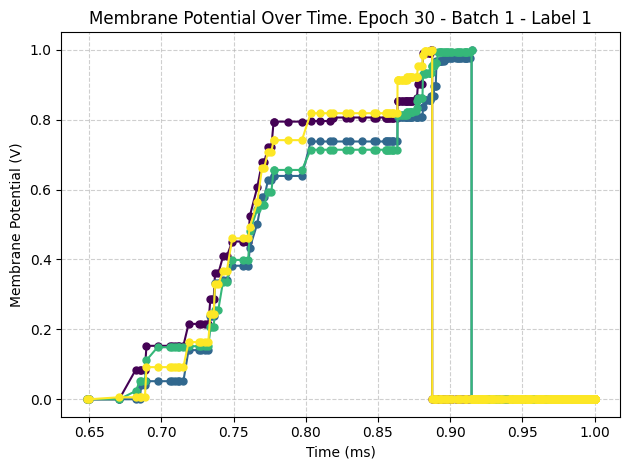

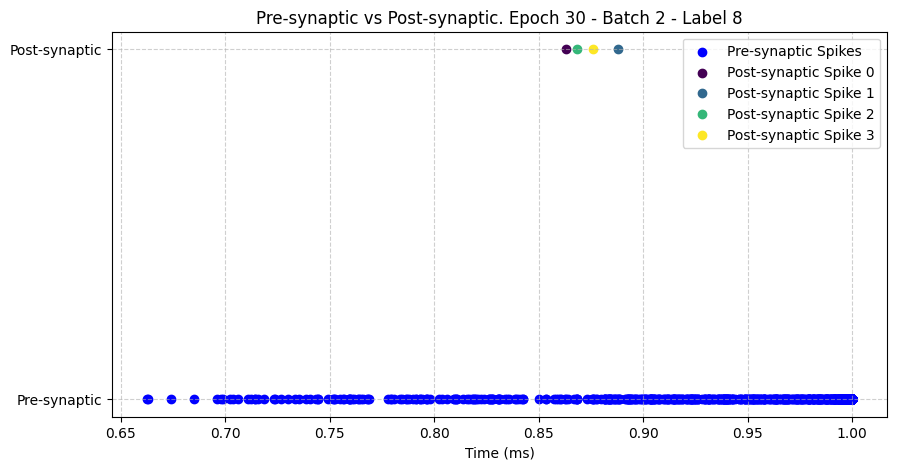

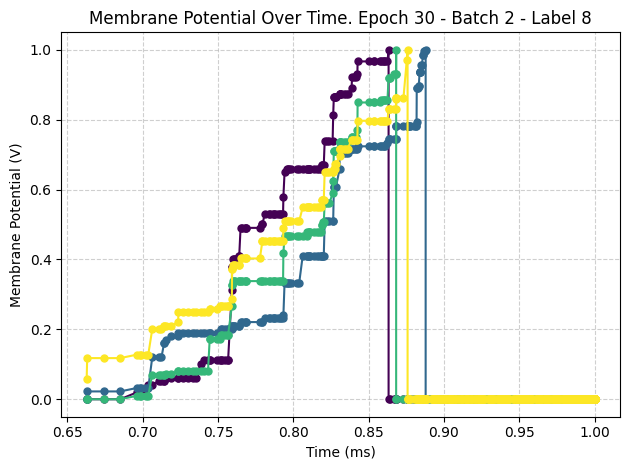

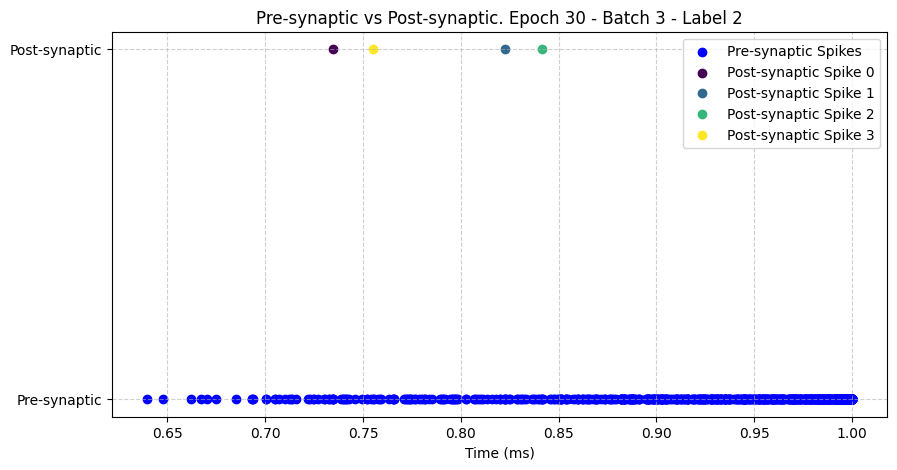

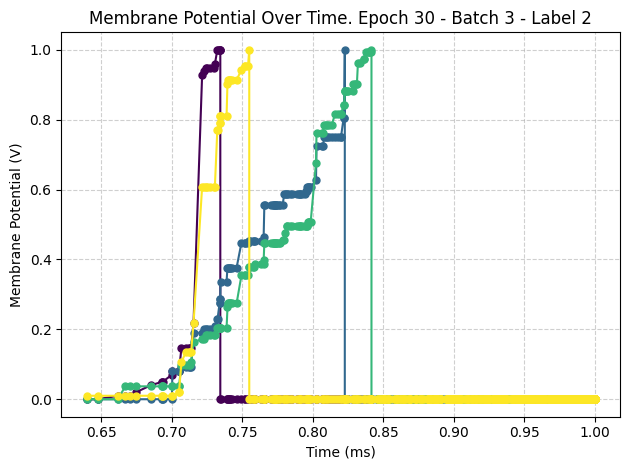

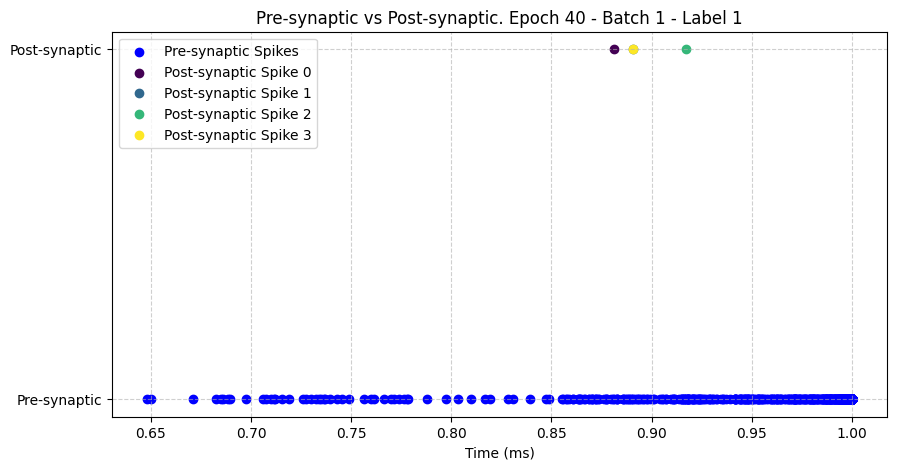

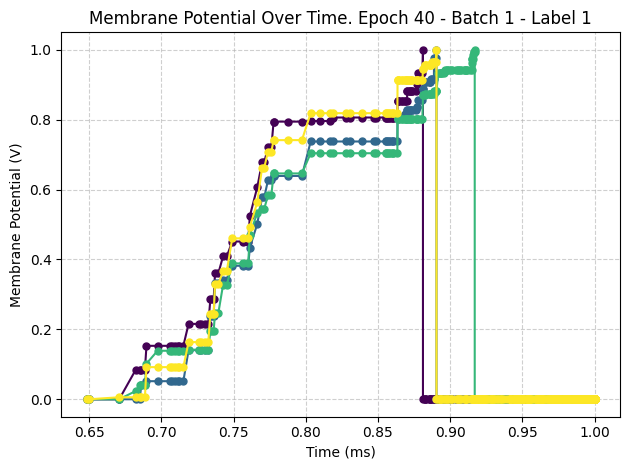

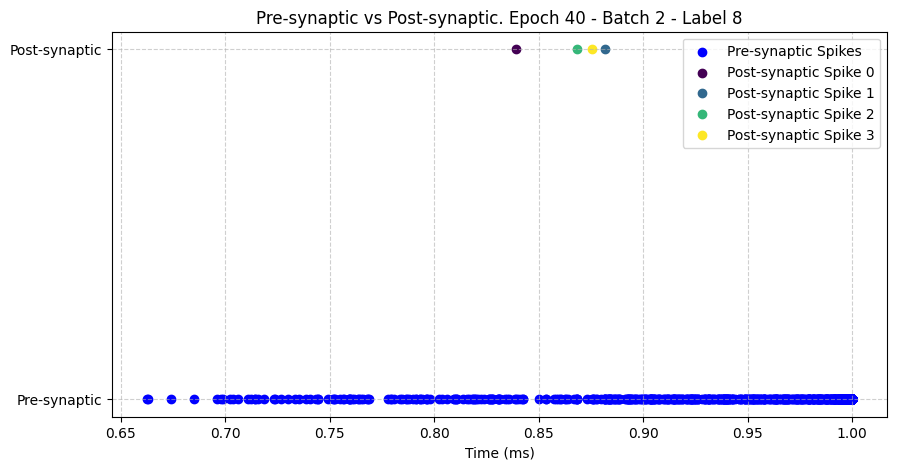

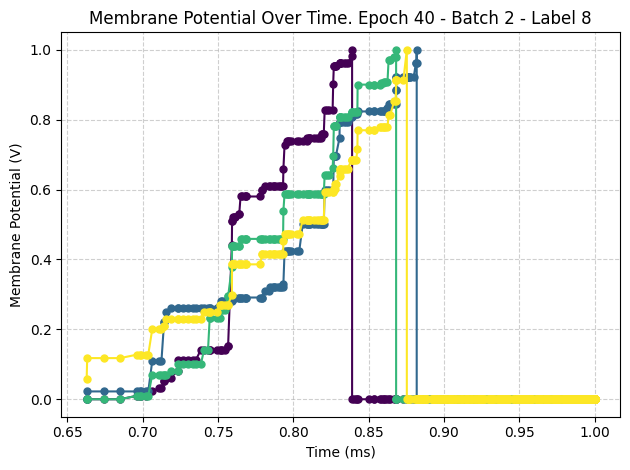

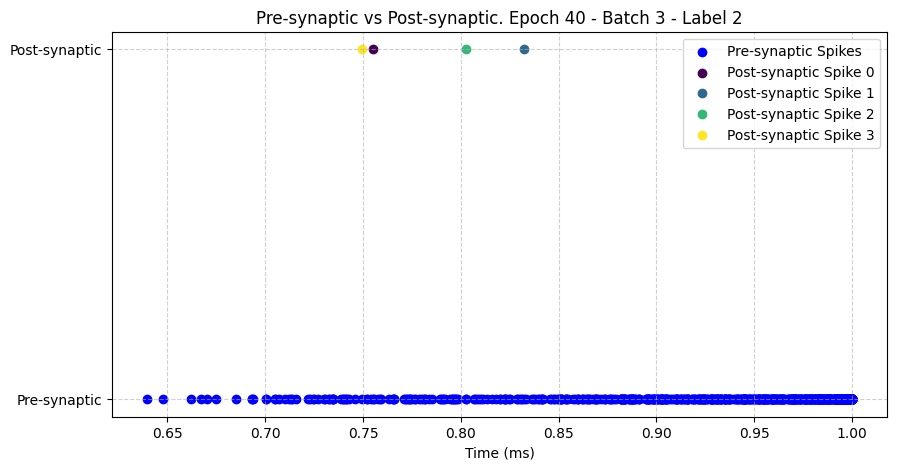

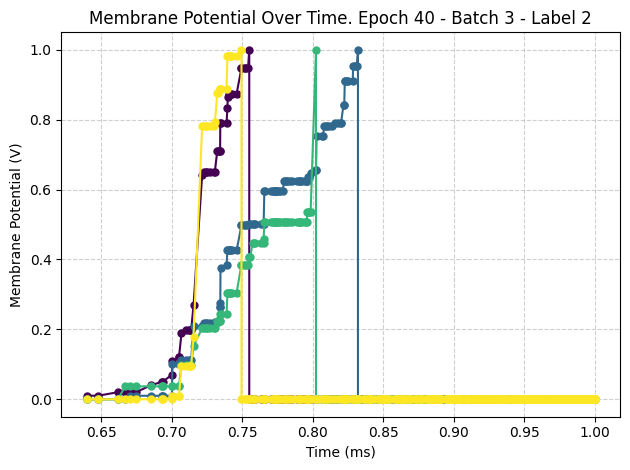

In [6]:
num_epochs = 40
if_layer = IntegrateAndFireLayer(num_inputs=max_input_spikes, num_outputs=4, threshold=1.0, refractory_period=np.inf)
stdp = STDP()
wta = WinnerTakesAll()

for epoch_idx in range(1, num_epochs + 1):
    for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):
        membrane_potentials = []
        membrane_potentials_times = []
        
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            output_spike = if_layer.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
            
            if np.any(output_spike == 1.0):
                membrane_potentials.append([
                    neuron.threshold if output_spike[neuron_idx] else neuron.membrane_potential
                    for neuron_idx, neuron in enumerate(if_layer.neurons)
                ])
                membrane_potentials_times.append(current_time)
            membrane_potentials.append([neuron.membrane_potential for neuron in if_layer.neurons])
            membrane_potentials_times.append(current_time)
        
        pre_spike_times = times.flatten()
        if_layer.backward(pre_spike_times, learning_mechanism=stdp, competition_mechanism=wta)
        post_spike_times = if_layer.spike_times

        if epoch_idx % 10 == 0 and batch_idx <= 3:
            SpikesVisualization.plot_pre_post_spikes(
                pre_spike_times,
                post_spike_times,
                title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}",
                unique_colors=True
            )
            SpikesVisualization.plot_multiple_membrane_potentials(
                membrane_potentials,
                membrane_potentials_times,
                title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}"
            )
        
        if_layer.reset()

In [18]:
def dataloader_to_spike_times(model, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(if_layer.spike_times)
        y.append(label)
        model.reset()
    return np.array(X), np.array(y)

In [19]:
def eval_snn(model):
    X_train, y_train = dataloader_to_spike_times(model, dataloader)
    X_test, y_test = dataloader_to_spike_times(model, validation_dataloader)
    print(f"{X_train.shape = }, {y_train.shape = }")
    print(f"{X_test.shape = }, {y_test.shape = }")

    classifier = LinearSVC()
    classifier.fit(X_train, y_train)
    
    print("Train accuracy:", accuracy_score(y_train, classifier.predict(X_train)))
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.title("Train Data Visualized with PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid()
    plt.show()
    
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

X_train.shape = (600, 4), y_train.shape = (600,)
X_test.shape = (100, 4), y_test.shape = (100,)
Train accuracy: 0.2


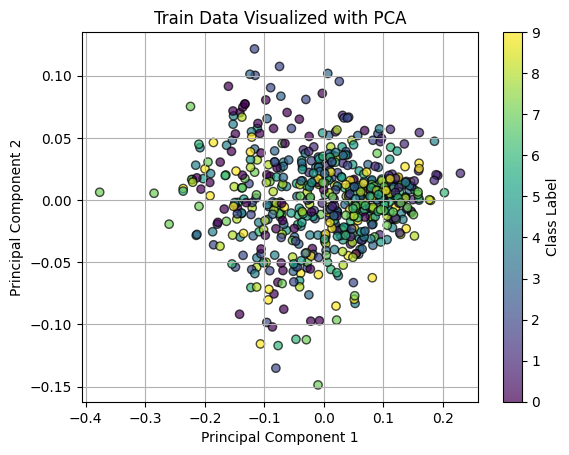

Accuracy: 0.17
Precision: 0.11
Recall: 0.17
F1 Score: 0.10
Confusion Matrix:
[[4 1 0 0 0 0 3 0 0 2]
 [0 9 0 0 0 0 0 0 1 0]
 [6 2 0 1 0 0 1 0 0 0]
 [5 3 0 1 0 0 1 0 0 0]
 [1 6 0 2 0 0 0 0 0 1]
 [4 4 0 0 0 0 0 0 0 2]
 [0 5 0 1 0 0 0 1 1 2]
 [3 6 0 1 0 0 0 0 0 0]
 [5 0 0 1 0 0 0 0 2 2]
 [2 6 0 0 0 0 1 0 0 1]]


/Users/Razvan/Uni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
eval_snn(if_layer)

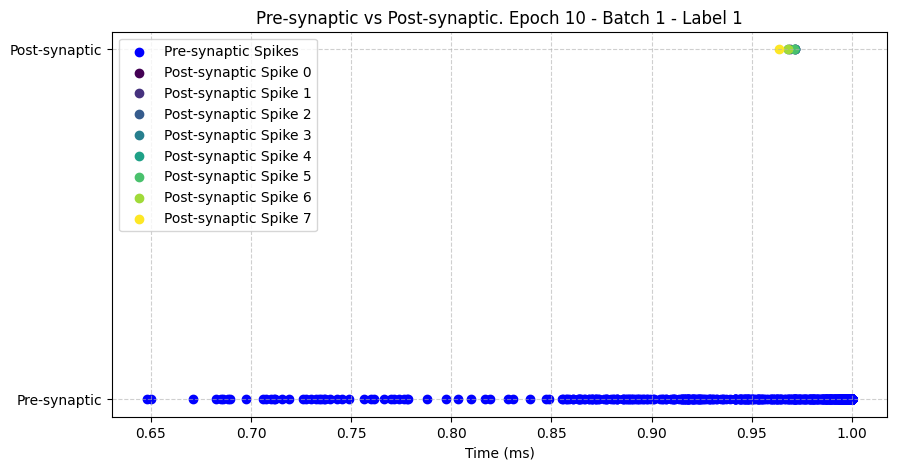

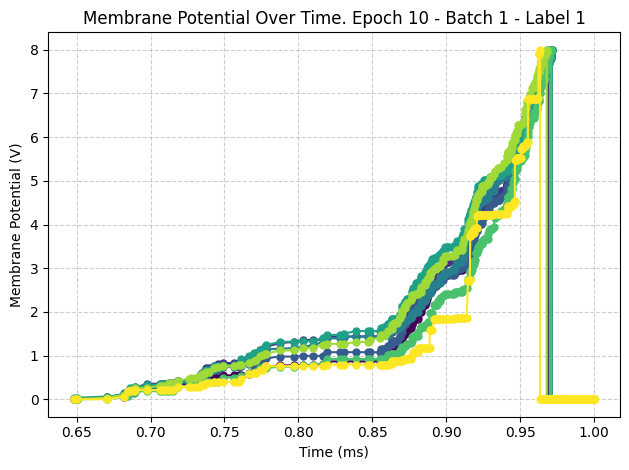

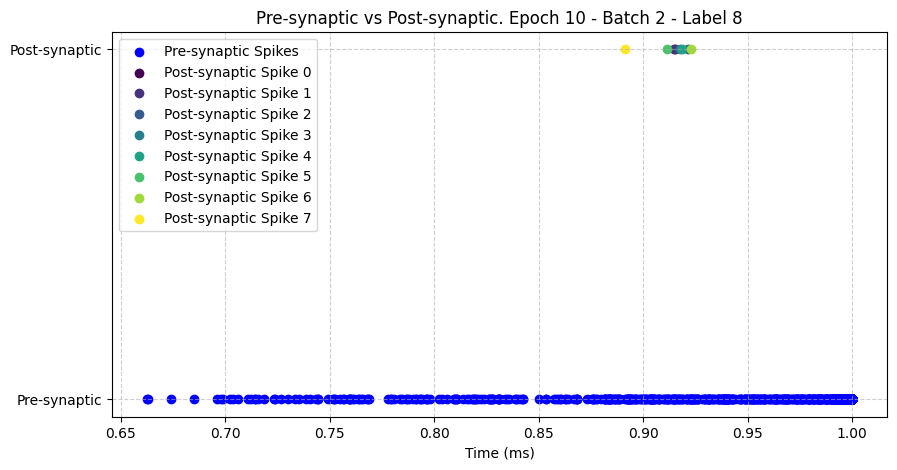

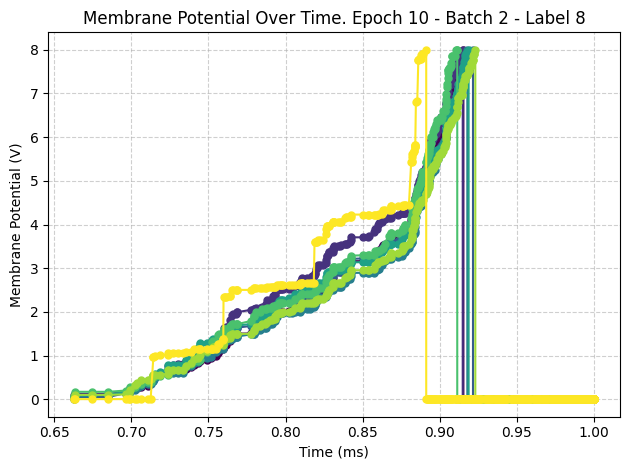

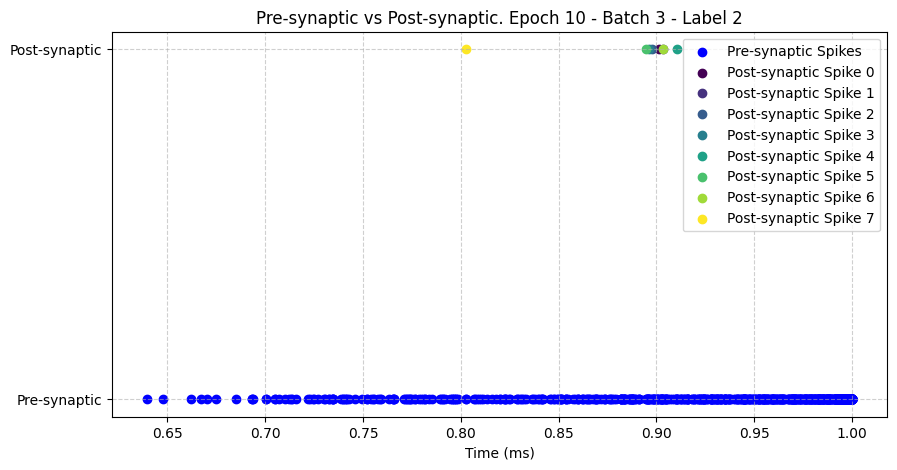

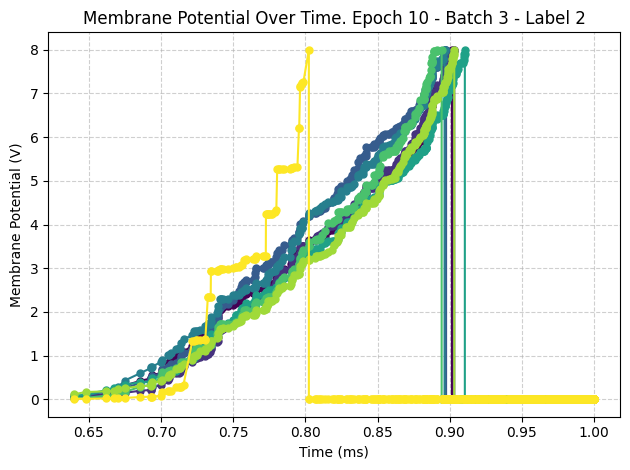

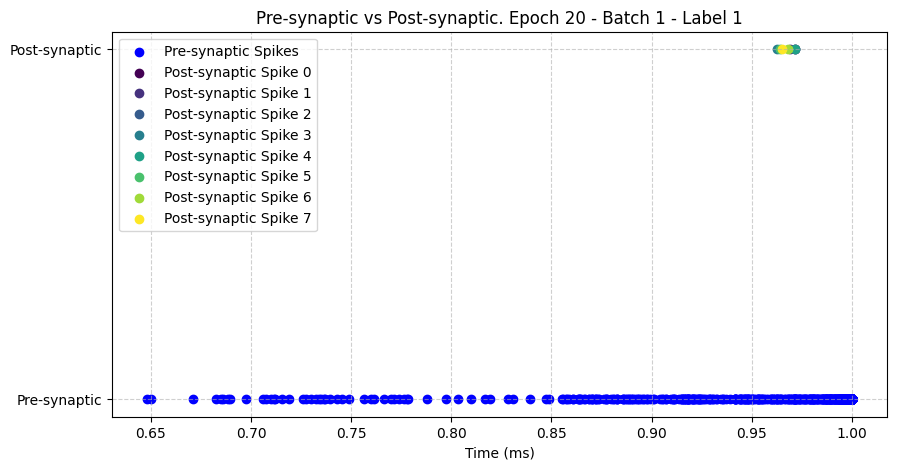

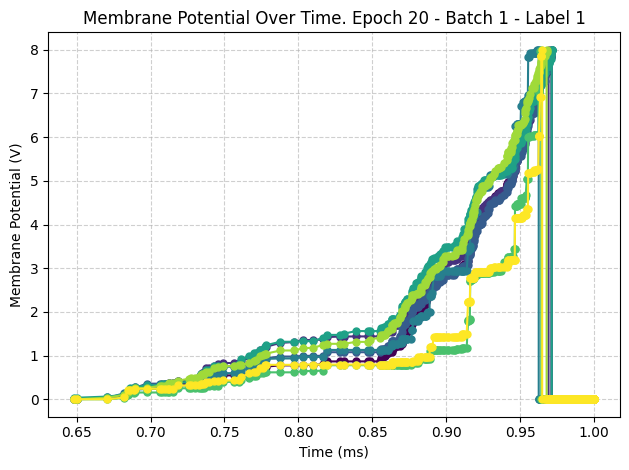

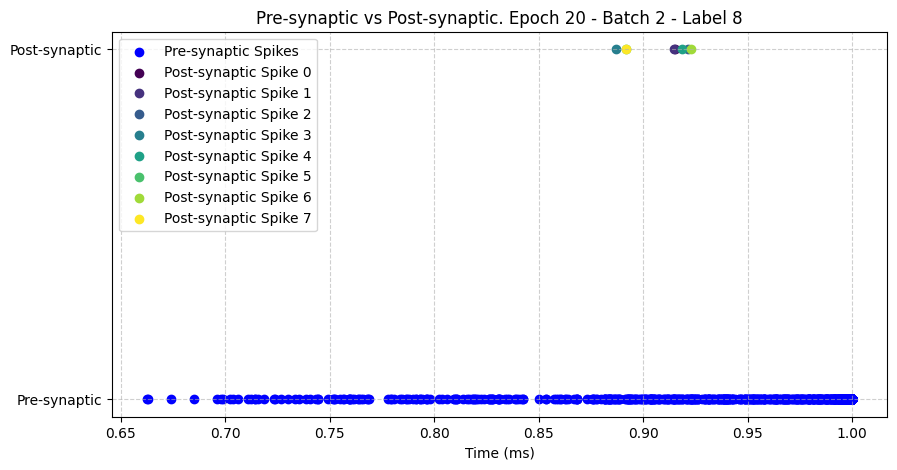

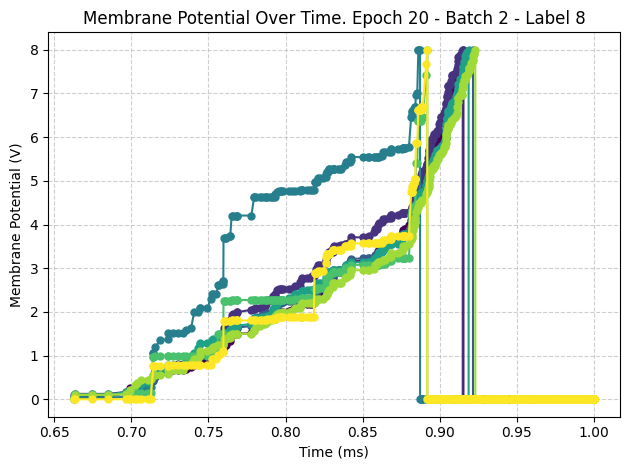

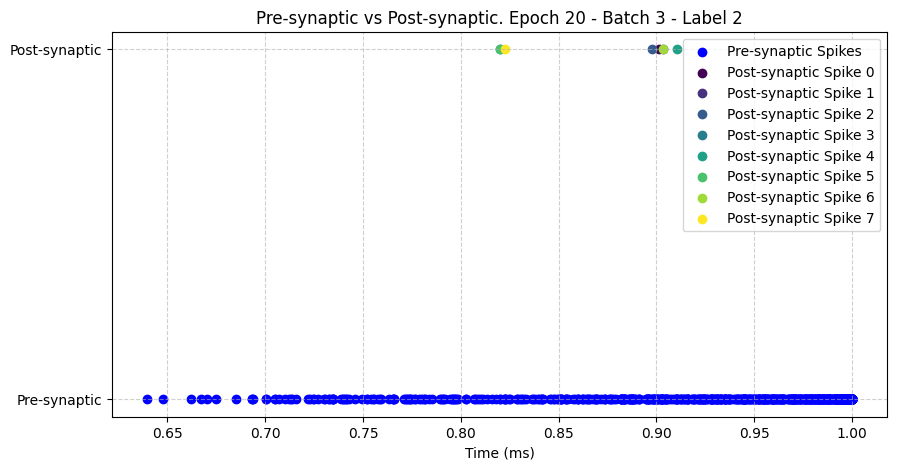

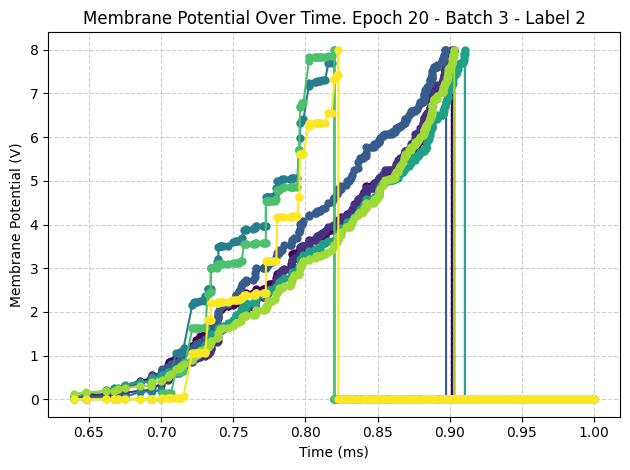

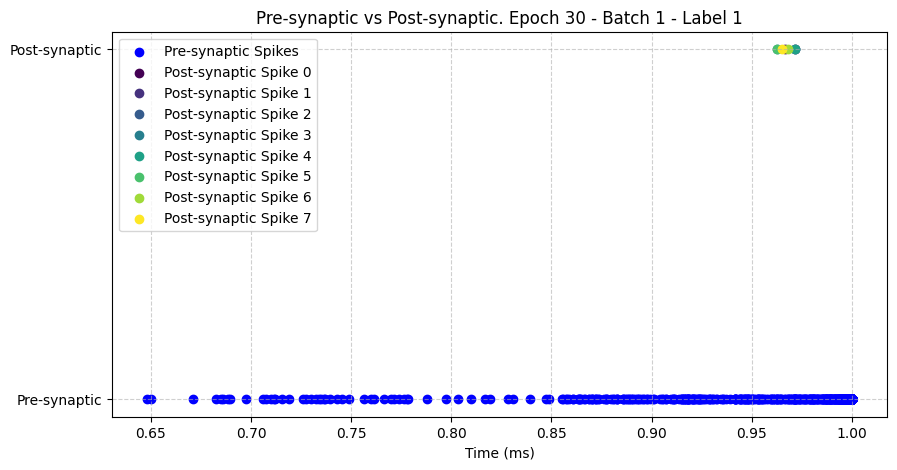

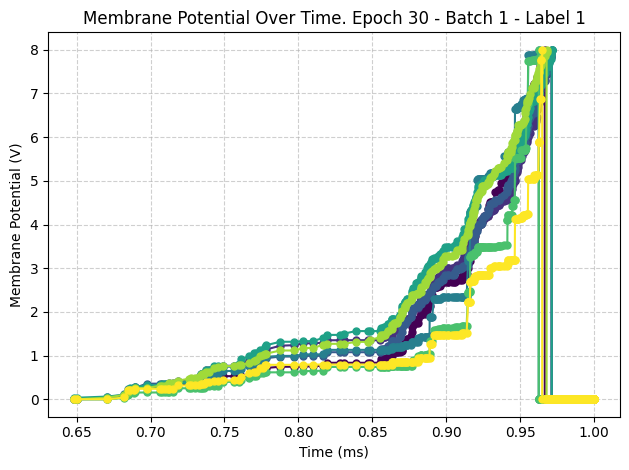

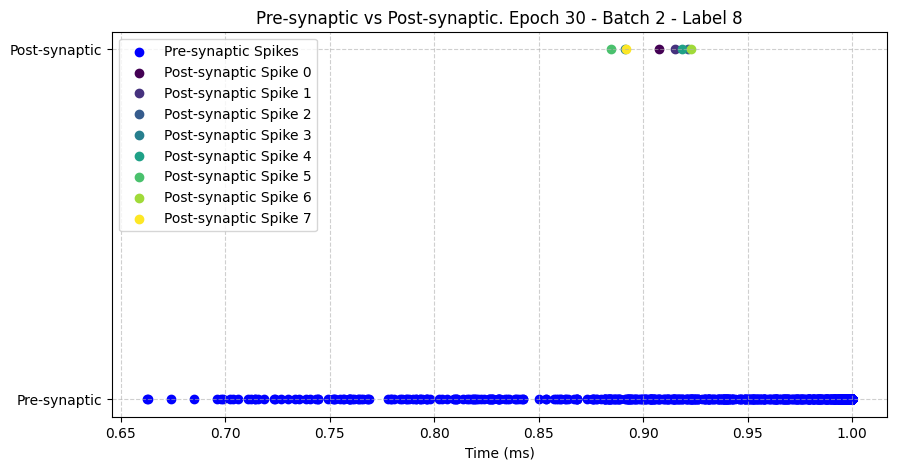

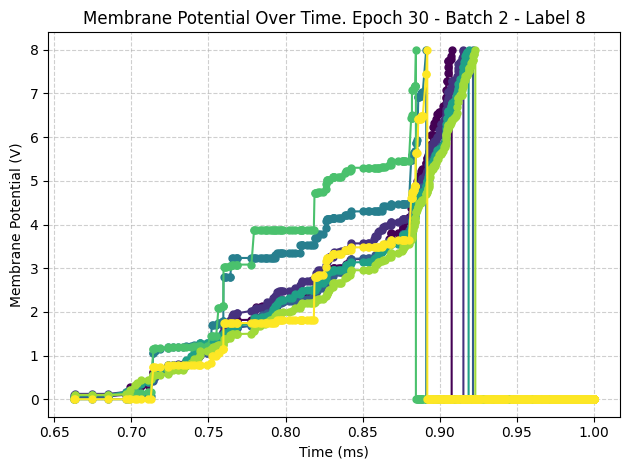

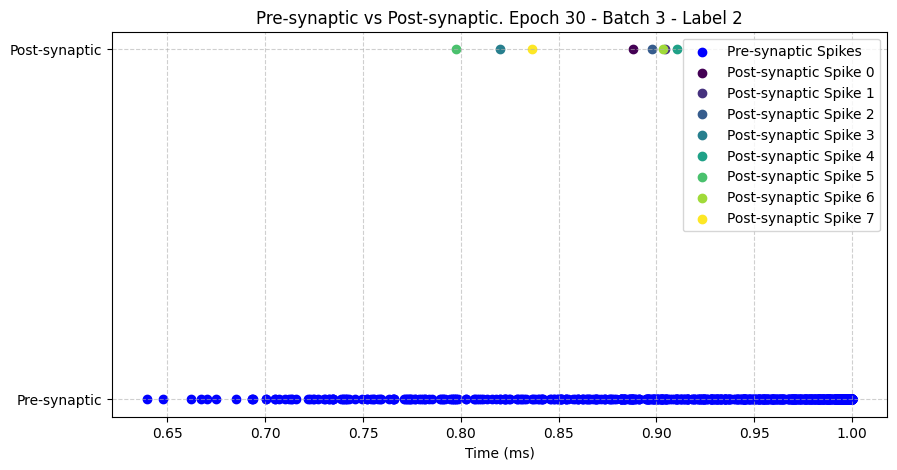

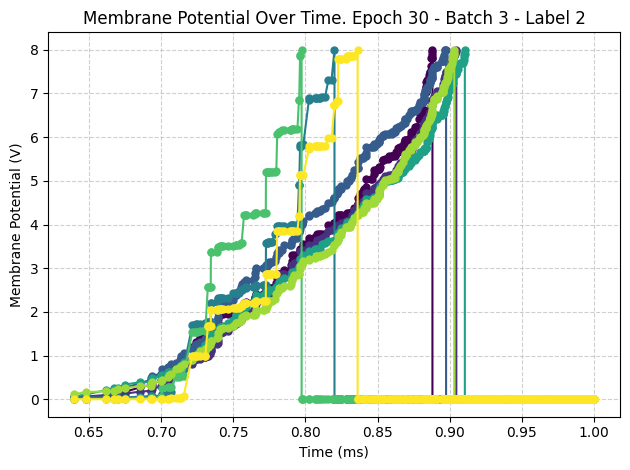

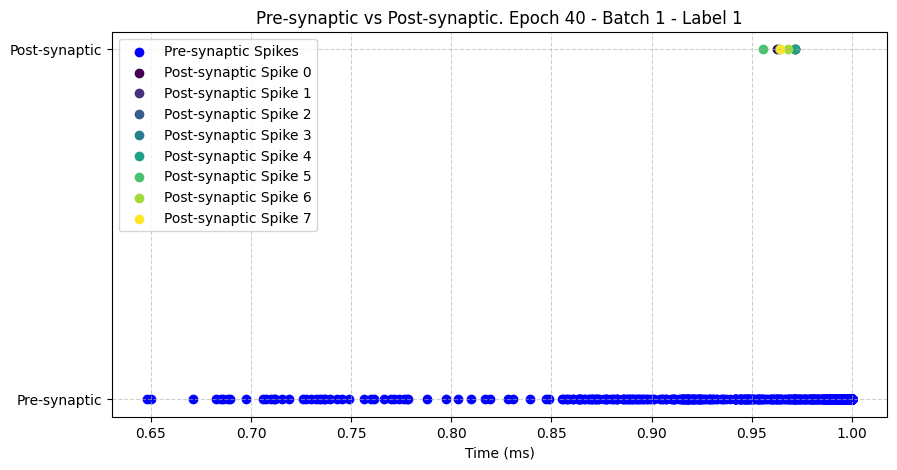

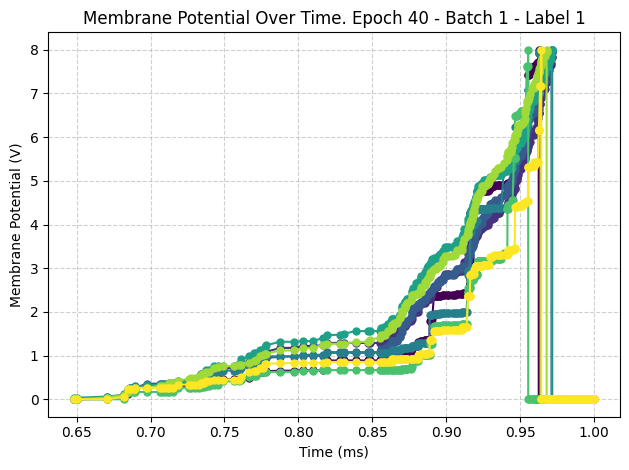

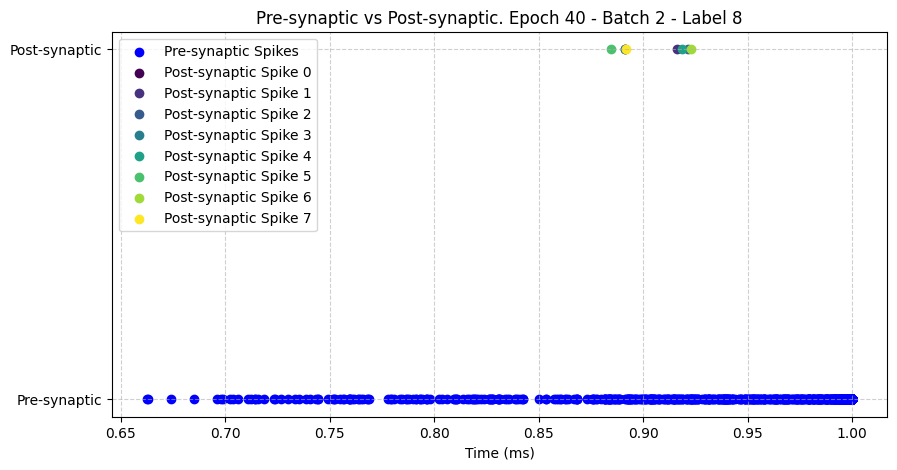

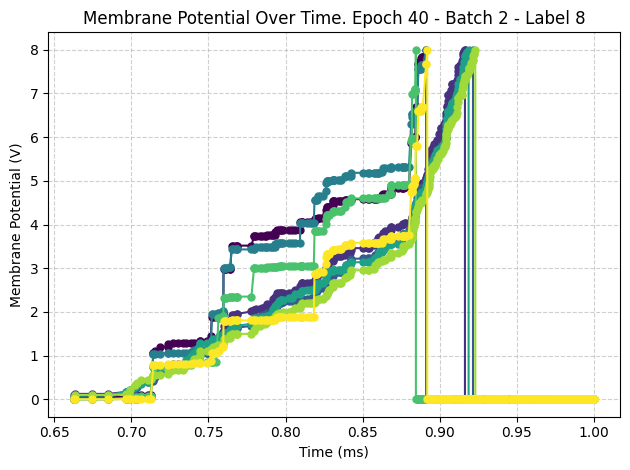

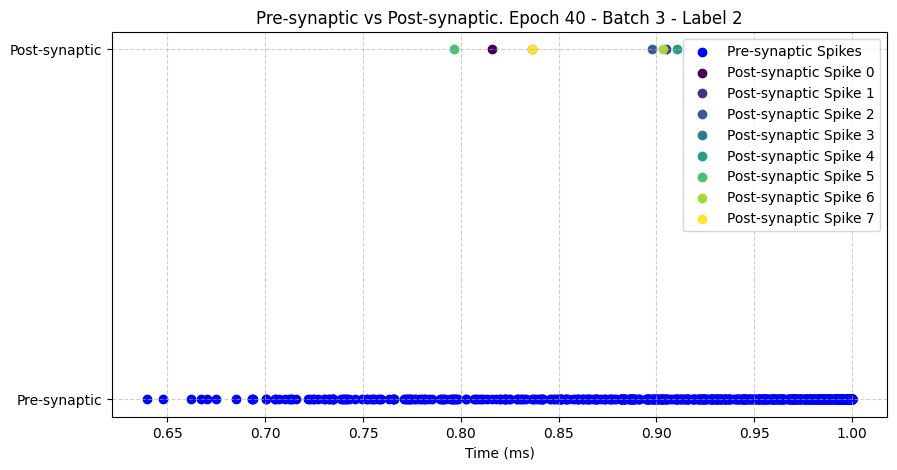

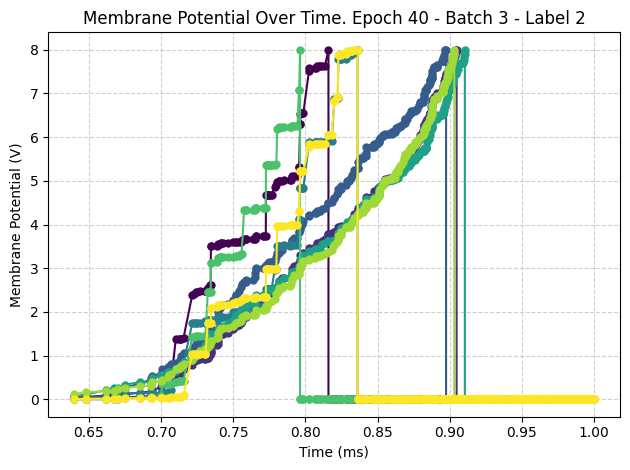

In [23]:
num_epochs = 40
if_layer = IntegrateAndFireLayer(num_inputs=max_input_spikes, num_outputs=8, threshold=8.0, refractory_period=np.inf)
stdp = STDP()
wta = WinnerTakesAll()

for epoch_idx in range(1, num_epochs + 1):
    for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):
        membrane_potentials = []
        membrane_potentials_times = []
        
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            output_spike = if_layer.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
            
            if np.any(output_spike == 1.0):
                membrane_potentials.append([
                    neuron.threshold if output_spike[neuron_idx] else neuron.membrane_potential
                    for neuron_idx, neuron in enumerate(if_layer.neurons)
                ])
                membrane_potentials_times.append(current_time)
            membrane_potentials.append([neuron.membrane_potential for neuron in if_layer.neurons])
            membrane_potentials_times.append(current_time)
        
        pre_spike_times = times.flatten()
        if_layer.backward(pre_spike_times, learning_mechanism=stdp, competition_mechanism=wta)
        post_spike_times = if_layer.spike_times

        if epoch_idx % 10 == 0 and batch_idx <= 3:
            SpikesVisualization.plot_pre_post_spikes(
                pre_spike_times,
                post_spike_times,
                title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}",
                unique_colors=True
            )
            SpikesVisualization.plot_multiple_membrane_potentials(
                membrane_potentials,
                membrane_potentials_times,
                title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}"
            )
        
        if_layer.reset()

X_train.shape = (600, 8), y_train.shape = (600,)
X_test.shape = (100, 8), y_test.shape = (100,)
Train accuracy: 0.30333333333333334


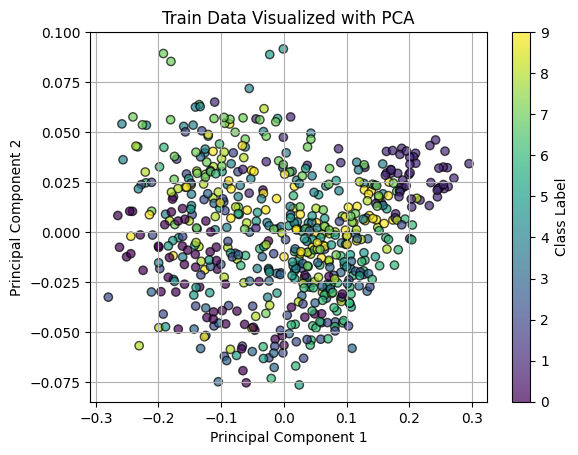

Accuracy: 0.32
Precision: 0.26
Recall: 0.32
F1 Score: 0.24
Confusion Matrix:
[[ 5  2  1  1  0  0  1  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 3  2  3  0  0  0  2  0  0  0]
 [ 3  2  1  1  0  0  2  1  0  0]
 [ 1  5  0  0  1  0  1  2  0  0]
 [ 4  4  1  0  0  0  0  1  0  0]
 [ 0  6  0  0  0  0  4  0  0  0]
 [ 0  2  0  0  0  0  0  8  0  0]
 [ 1  2  0  0  3  0  1  3  0  0]
 [ 0  6  0  0  0  0  3  1  0  0]]


/Users/Razvan/Uni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
eval_snn(if_layer)

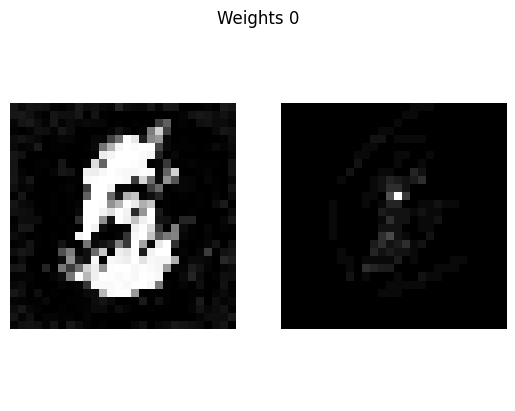

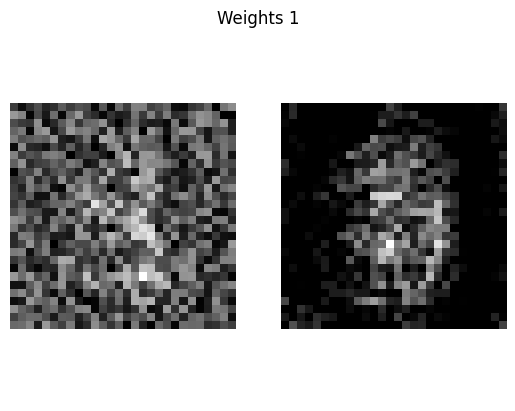

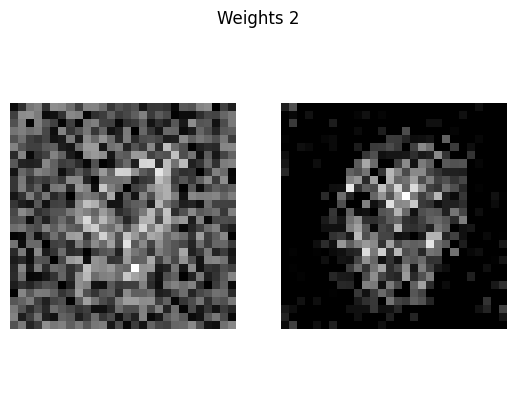

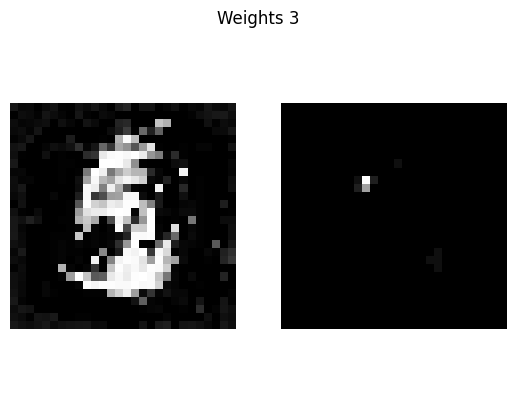

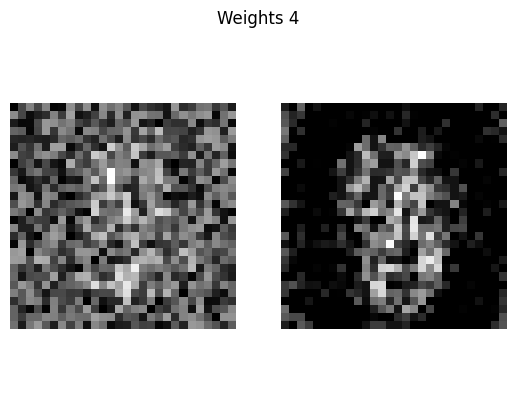

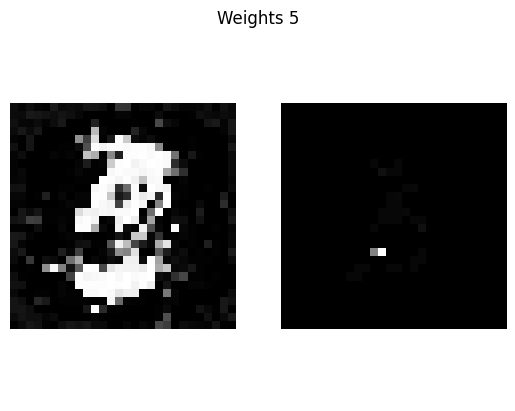

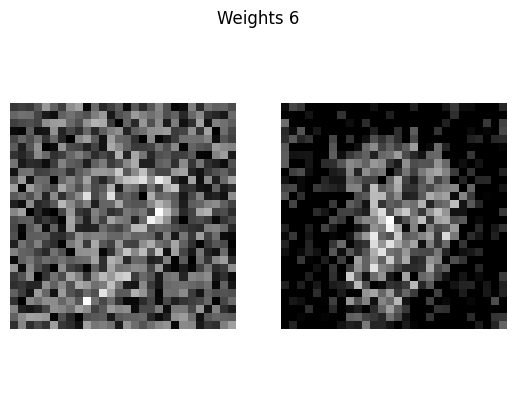

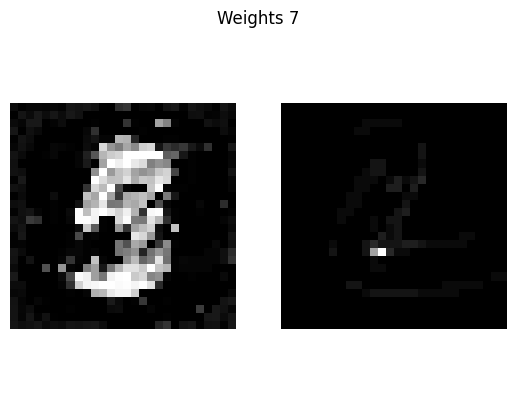

In [40]:
for i in range(8):
    img = if_layer.neurons[i].weights.reshape((max_z, max_x, max_y))
    plt.title(f"Weights {i}")
    plt.axis("off")
    plt.subplot(1, 2, 1)
    plt.imshow(img[0, :, :], cmap='grey')
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img[1, :, :], cmap='grey')
    plt.axis("off")
    plt.show()